In [46]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [47]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=55940699b2996b7bb38e31391983b9bff2b835f3013362a0363733cd06b2c1d7
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [48]:
FOLDS = 10
ESTIMATORS = 1000
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
NON_FEATURES = set(TARGET) | {'pid', 'week_last_1', 'week_last_2', 'week_last_3'}
CATEGORICALS = {'sex', 'smoking'}
SCORING = 'neg_root_mean_squared_error'

In [49]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [50]:
train = pd.read_parquet(f'{DATA}/cvtrain.parquet')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             174 non-null    object 
 1   age             174 non-null    uint8  
 2   sex             174 non-null    object 
 3   smoking         174 non-null    object 
 4   week_1          174 non-null    int16  
 5   fvc_1           174 non-null    uint16 
 6   percent_1       174 non-null    float32
 7   fvc_last_1      174 non-null    uint16 
 8   fvc_last_2      174 non-null    uint16 
 9   fvc_last_3      174 non-null    uint16 
 10  week_last_1     174 non-null    int16  
 11  week_last_2     174 non-null    int16  
 12  week_last_3     174 non-null    int16  
 13  fvc_last_1_min  174 non-null    float32
 14  fvc_last_1_p50  174 non-null    float32
 15  fvc_last_1_p75  174 non-null    float32
 16  fvc_last_1_p90  174 non-null    float32
 17  fvc_last_1_p95  174 non-null    flo

In [51]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,2008.047607,2166.488525,2218.489990,2261.252197,2273.078613,2288.827148,2293.754395,1995.286133,2152.624756,2204.309814,2246.818115,2258.554932,2274.212402,2279.119141,2062.616455,2225.209473,2278.671875,2322.622559,2334.745361,2350.954346,2356.034912
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,2018.092529,2299.831299,2350.122070,2374.165527,2386.951416,2406.859619,2438.300537,2005.254272,2285.085449,2335.061523,2358.945557,2371.639648,2391.426025,2422.645996,2072.975586,2362.251953,2413.893311,2438.608398,2451.744141,2472.179688,2504.459717
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,2030.324951,2285.276367,2368.145996,2404.446045,2410.665771,2437.612793,2459.913086,2017.426270,2270.633545,2352.968018,2389.009766,2395.194336,2421.962158,2444.112305,2085.491211,2347.295410,2432.350098,2469.629883,2475.991211,2503.668701,2526.614990
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,1957.703491,2267.683594,2412.646973,2424.831299,2439.296387,2471.139893,2472.631348,1945.258423,2253.208008,2397.190918,2409.274414,2423.660645,2455.282715,2456.767578,2010.960083,2329.215088,2478.108398,2490.584961,2505.481201,2538.166016,2539.718018
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,2009.789429,2240.865234,2360.055176,2396.740723,2410.666992,2434.207520,2439.552979,1997.049194,2226.604980,2345.000732,2381.401123,2395.281006,2418.658203,2423.964844,2064.418457,2301.737061,2424.079102,2461.700684,2476.105469,2500.291260,2505.783203


In [52]:
def encode(df, col, encoder) -> None:
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()

 
for col in CATEGORICALS:
    encoder = dict(train[col].value_counts(normalize=True))
    print(f'col={col}, encoder={encoder}')
    encode(train, col, encoder)

col=smoking, encoder={'Ex-smoker': 0.6666666666666666, 'Never smoked': 0.28160919540229884, 'Currently smokes': 0.05172413793103448}
col=sex, encoder={'Male': 0.7873563218390804, 'Female': 0.21264367816091953}


In [53]:
FEATURES = set(train.columns) - NON_FEATURES
FEATURES = list(FEATURES)
FEATURES.sort()
print(f'{len(FEATURES)} FEATURES={FEATURES}')

27 FEATURES=['age', 'fvc_1', 'fvc_last_1_max', 'fvc_last_1_min', 'fvc_last_1_p50', 'fvc_last_1_p75', 'fvc_last_1_p90', 'fvc_last_1_p95', 'fvc_last_1_p99', 'fvc_last_2_max', 'fvc_last_2_min', 'fvc_last_2_p50', 'fvc_last_2_p75', 'fvc_last_2_p90', 'fvc_last_2_p95', 'fvc_last_2_p99', 'fvc_last_3_max', 'fvc_last_3_min', 'fvc_last_3_p50', 'fvc_last_3_p75', 'fvc_last_3_p90', 'fvc_last_3_p95', 'fvc_last_3_p99', 'percent_1', 'sex', 'smoking', 'week_1']


In [54]:
x_train = train[FEATURES]

In [55]:
%%time
models = []
results = []


for col in TARGET:
    y_train = train[col]
    model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__learning_rate': [0.01, 0.001],
        'model__subsample': [0.01, 0.05, 0.1],
        'model__min_child_samples': [20, 40, 80],
        'model__colsample_bytree': [0.2, 0.3, 0.4]
    }
    lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    lgbm.fit(x_train, y_train)
    best_score = lgbm.best_score_
    best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
    print(f"""LGBM y={col}
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
    """)
    res = pd.DataFrame.from_dict(lgbm.cv_results_)
    res.set_index('rank_test_score', inplace=True)
    res.sort_index(inplace=True)
    models.append(lgbm)
    results.append(res)

LGBM y=fvc_last_3
best params={'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-322.131, std=62.195
    
LGBM y=fvc_last_2
best params={'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-344.379, std=73.336
    
LGBM y=fvc_last_1
best params={'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-371.567, std=71.193
    
CPU times: user 9min 46s, sys: 22.2 s, total: 10min 8s
Wall time: 1min 46s


In [56]:
results[0].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.122111,0.014379,0.001883,0.000165,0.4,0.01,20,0.05,"{'model__colsample_bytree': 0.4, 'model__learn...",-343.176041,-350.564847,-364.372760,-296.699645,-320.636788,-468.471471,-266.518370,-231.997016,-300.092565,-278.776118,-322.130562,62.195259
1,0.108124,0.004534,0.002054,0.000412,0.4,0.01,20,0.01,"{'model__colsample_bytree': 0.4, 'model__learn...",-343.176041,-350.564847,-364.372760,-296.699645,-320.636788,-468.471471,-266.518370,-231.997016,-300.092565,-278.776118,-322.130562,62.195259
1,0.108049,0.003819,0.001890,0.000314,0.4,0.01,20,0.1,"{'model__colsample_bytree': 0.4, 'model__learn...",-343.176041,-350.564847,-364.372760,-296.699645,-320.636788,-468.471471,-266.518370,-231.997016,-300.092565,-278.776118,-322.130562,62.195259
4,0.109954,0.004099,0.002247,0.000544,0.3,0.01,20,0.05,"{'model__colsample_bytree': 0.3, 'model__learn...",-342.047971,-346.567813,-381.358279,-336.673079,-311.962523,-467.914847,-280.046415,-239.763400,-303.525428,-289.628635,-329.948839,59.511707
4,0.109495,0.004885,0.001782,0.000048,0.3,0.01,20,0.1,"{'model__colsample_bytree': 0.3, 'model__learn...",-342.047971,-346.567813,-381.358279,-336.673079,-311.962523,-467.914847,-280.046415,-239.763400,-303.525428,-289.628635,-329.948839,59.511707
4,0.116274,0.003901,0.001859,0.000073,0.3,0.01,20,0.01,"{'model__colsample_bytree': 0.3, 'model__learn...",-342.047971,-346.567813,-381.358279,-336.673079,-311.962523,-467.914847,-280.046415,-239.763400,-303.525428,-289.628635,-329.948839,59.511707
7,0.095618,0.006750,0.001835,0.000111,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-328.439789,-352.679545,-401.088758,-404.320292,-316.313814,-490.361366,-334.386457,-265.158115,-317.082520,-333.975246,-354.380590,59.547658
7,0.098066,0.009749,0.001787,0.000090,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-328.439789,-352.679545,-401.088758,-404.320292,-316.313814,-490.361366,-334.386457,-265.158115,-317.082520,-333.975246,-354.380590,59.547658
7,0.099847,0.013253,0.001785,0.000053,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-328.439789,-352.679545,-401.088758,-404.320292,-316.313814,-490.361366,-334.386457,-265.158115,-317.082520,-333.975246,-354.380590,59.547658


In [57]:
results[1].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.099818,0.001608,0.001825,0.000143,0.4,0.01,20,0.05,"{'model__colsample_bytree': 0.4, 'model__learn...",-345.376794,-375.179952,-363.121467,-301.667362,-338.790508,-537.866581,-334.736919,-275.850790,-312.878346,-258.318576,-344.378729,73.336012
1,0.102421,0.005413,0.001848,0.000187,0.4,0.01,20,0.01,"{'model__colsample_bytree': 0.4, 'model__learn...",-345.376794,-375.179952,-363.121467,-301.667362,-338.790508,-537.866581,-334.736919,-275.850790,-312.878346,-258.318576,-344.378729,73.336012
1,0.099794,0.001498,0.001778,0.000080,0.4,0.01,20,0.1,"{'model__colsample_bytree': 0.4, 'model__learn...",-345.376794,-375.179952,-363.121467,-301.667362,-338.790508,-537.866581,-334.736919,-275.850790,-312.878346,-258.318576,-344.378729,73.336012
4,0.099709,0.003758,0.001766,0.000025,0.3,0.01,20,0.05,"{'model__colsample_bytree': 0.3, 'model__learn...",-350.060848,-366.645093,-379.787720,-343.367471,-349.144862,-542.272769,-347.631857,-291.386943,-315.370097,-270.593280,-355.626094,69.862105
4,0.097985,0.003044,0.001753,0.000041,0.3,0.01,20,0.1,"{'model__colsample_bytree': 0.3, 'model__learn...",-350.060848,-366.645093,-379.787720,-343.367471,-349.144862,-542.272769,-347.631857,-291.386943,-315.370097,-270.593280,-355.626094,69.862105
4,0.098713,0.002718,0.001774,0.000052,0.3,0.01,20,0.01,"{'model__colsample_bytree': 0.3, 'model__learn...",-350.060848,-366.645093,-379.787720,-343.367471,-349.144862,-542.272769,-347.631857,-291.386943,-315.370097,-270.593280,-355.626094,69.862105
7,0.102560,0.006002,0.001941,0.000373,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-342.982848,-382.600678,-407.528025,-428.496058,-366.400654,-566.393670,-369.969416,-327.923019,-344.283923,-326.574771,-386.315306,67.792272
7,0.104575,0.005806,0.001849,0.000199,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-342.982848,-382.600678,-407.528025,-428.496058,-366.400654,-566.393670,-369.969416,-327.923019,-344.283923,-326.574771,-386.315306,67.792272
7,0.142117,0.104492,0.002066,0.000318,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-342.982848,-382.600678,-407.528025,-428.496058,-366.400654,-566.393670,-369.969416,-327.923019,-344.283923,-326.574771,-386.315306,67.792272


In [58]:
results[2].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.110699,0.011904,0.001864,0.000187,0.4,0.01,20,0.05,"{'model__colsample_bytree': 0.4, 'model__learn...",-409.778024,-395.557248,-420.190814,-299.834396,-464.934364,-492.191914,-325.722729,-277.882631,-298.269635,-331.307423,-371.566918,71.193459
1,0.112406,0.005338,0.001921,0.000179,0.4,0.01,20,0.01,"{'model__colsample_bytree': 0.4, 'model__learn...",-409.778024,-395.557248,-420.190814,-299.834396,-464.934364,-492.191914,-325.722729,-277.882631,-298.269635,-331.307423,-371.566918,71.193459
1,0.106540,0.006928,0.001920,0.000186,0.4,0.01,20,0.1,"{'model__colsample_bytree': 0.4, 'model__learn...",-409.778024,-395.557248,-420.190814,-299.834396,-464.934364,-492.191914,-325.722729,-277.882631,-298.269635,-331.307423,-371.566918,71.193459
4,0.112954,0.011533,0.001936,0.000310,0.3,0.01,20,0.05,"{'model__colsample_bytree': 0.3, 'model__learn...",-405.376346,-408.094403,-435.988205,-328.016469,-485.540709,-500.850505,-327.779105,-291.270818,-289.530237,-326.031721,-379.847852,73.966829
4,0.104788,0.008248,0.001850,0.000160,0.3,0.01,20,0.1,"{'model__colsample_bytree': 0.3, 'model__learn...",-405.376346,-408.094403,-435.988205,-328.016469,-485.540709,-500.850505,-327.779105,-291.270818,-289.530237,-326.031721,-379.847852,73.966829
4,0.156364,0.051041,0.002026,0.000270,0.3,0.01,20,0.01,"{'model__colsample_bytree': 0.3, 'model__learn...",-405.376346,-408.094403,-435.988205,-328.016469,-485.540709,-500.850505,-327.779105,-291.270818,-289.530237,-326.031721,-379.847852,73.966829
7,0.106760,0.006782,0.001775,0.000040,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-368.615585,-428.910113,-476.915124,-392.137059,-481.205822,-520.116179,-343.216081,-314.692901,-311.641353,-363.912994,-400.136321,69.593011
7,0.103314,0.003811,0.001960,0.000380,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-368.615585,-428.910113,-476.915124,-392.137059,-481.205822,-520.116179,-343.216081,-314.692901,-311.641353,-363.912994,-400.136321,69.593011
7,0.115695,0.017752,0.001854,0.000154,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-368.615585,-428.910113,-476.915124,-392.137059,-481.205822,-520.116179,-343.216081,-314.692901,-311.641353,-363.912994,-400.136321,69.593011


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

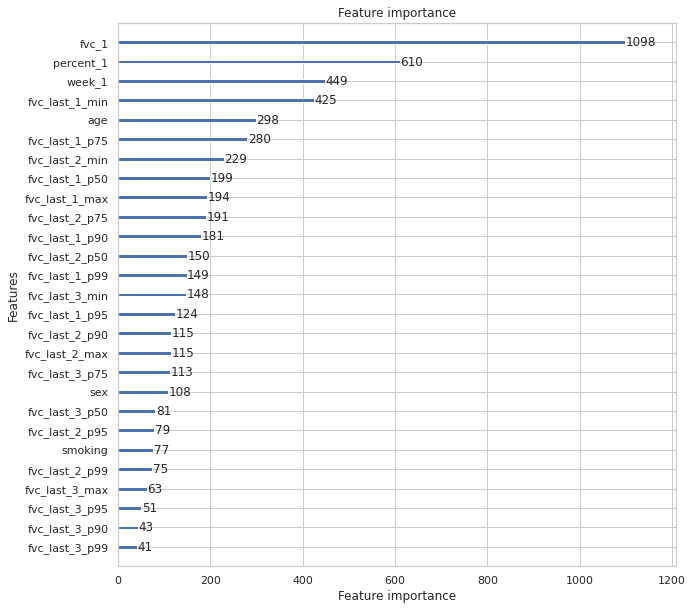

In [65]:
lgb.plot_importance(models[0].best_estimator_['model'], figsize=(10, 10))
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

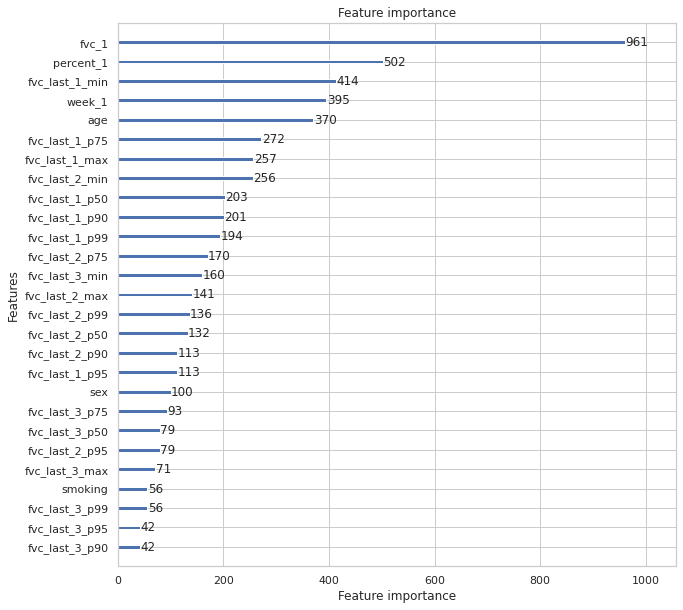

In [66]:
lgb.plot_importance(models[1].best_estimator_['model'], figsize=(10, 10))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

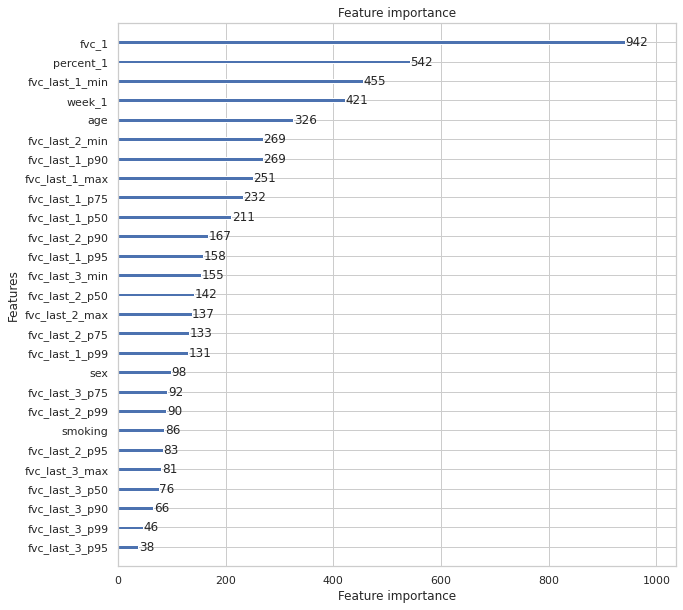

In [67]:
lgb.plot_importance(models[2].best_estimator_['model'], figsize=(10, 10))

In [62]:
for i in range(len(models)):
    y = TARGET[i]
    lgbm = models[i]
    lgbm.best_estimator_['model'].booster_.save_model(f'output/lgb_{y}.txt')